<h1 style = "color:Blue; text-align:center;">Sentiment Analytics</h1>


In [2]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation

import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import spacy


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sbedo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sbedo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h2 style = "color:#df3079;">Data Exploratation</h2>


In [3]:
data = pd.read_csv(r"Coursera_reviews.csv")
data.head()

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


In [5]:
data.shape

(1454711, 5)

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454711 entries, 0 to 1454710
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   reviews       1454558 non-null  object
 1   reviewers     1454711 non-null  object
 2   date_reviews  1454711 non-null  object
 3   rating        1454711 non-null  int64 
 4   course_id     1454711 non-null  object
dtypes: int64(1), object(4)
memory usage: 55.5+ MB
None


In [7]:
print(data.describe())

             rating
count  1.454711e+06
mean   4.696649e+00
std    6.983271e-01
min    1.000000e+00
25%    5.000000e+00
50%    5.000000e+00
75%    5.000000e+00
max    5.000000e+00


In [12]:
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
reviews,0
reviewers,0
date_reviews,0
rating,0
course_id,0


In [13]:
data.duplicated().sum()

934672

<Axes: xlabel='rating'>

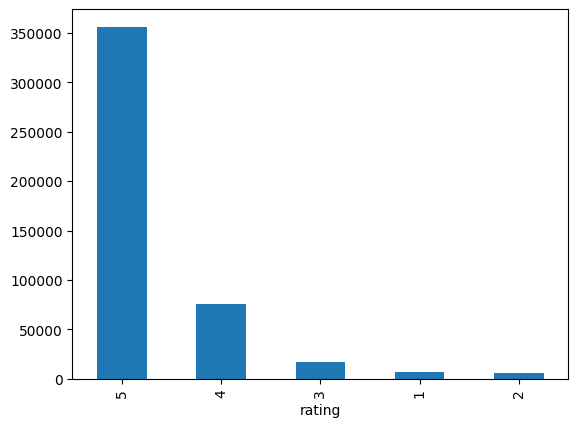

In [16]:
data['rating'].value_counts().plot(kind='bar')

In [17]:
data['rating'].value_counts()


rating
5    356174
4     75310
3     17212
1      6445
2      5999
Name: count, dtype: int64

<h2 style = "color:#00a67d;">Data Preprocessing</h2>


In [9]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 153

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


In [19]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['rating','reviews'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 0

Percentage of data removed: 0.0%
Percentage of data remaining: 31.7%


In [36]:
data.shape

(461140, 6)

In [20]:
data['rating'].value_counts()


rating
5    356174
4     75310
3     17212
1      6445
2      5999
Name: count, dtype: int64

In [31]:
# stopwords

# Get the stopwords for English and French

english_stopwords = set(stopwords.words('english'))
french_stopwords = set(stopwords.words('french'))
# arabic_stopwords = set(stopwords.words('arabic'))


# Combine the stopwords into a single set
total_stopwords = english_stopwords.union(french_stopwords) #.union(arabic_stopwords)

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

# 
final_stopwords.add("one")
print(final_stopwords)

{'fûtes', 'himself', 'seriez', 'our', 'avait', 'ou', 'vous', 'même', 'is', 'm', "she's", 'soient', 'to', 'or', 'these', 'étants', 'serai', 'toi', 'ces', 'sur', 'aurions', 'too', 'don', 'while', 'them', 'mightn', 'avec', 'étante', 'how', 'i', 'needn', 'from', 'an', 'other', 'during', 'aviez', 'isn', 'won', 'one', 'ayez', 'suis', 'after', 'est', 'him', 'your', 'for', 'aren', 'serais', 'fut', 'avez', "you'd", 'pas', 'it', "you're", 'l', 'la', 'same', 'aient', 'es', 'by', 'once', 'he', 'at', 'so', 'ayons', 'eussiez', 'des', 'ayante', 'shouldn', 'êtes', 'myself', 'me', 'mais', 'sois', 'ait', 'en', 'shan', 't', 'étions', 'tu', 'eussions', 'that', 'hasn', 'auras', 'de', 'having', 'can', 'serions', 'n', 'of', 'aura', 'aies', 'aurait', 'ain', 'eussent', 'were', 'who', 'wasn', 'being', 'une', 'in', 'than', 'serons', 'we', 'my', 'eûmes', 'should', 'aurons', 'son', 'does', 'avais', 'ont', 'sont', 'soit', 'itself', 'ne', 'furent', 'fussent', 'eût', 'on', 'le', 'soyez', 'ses', 'where', 'their', 'ver

In [32]:
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")

In [33]:
lemmatizer = WordNetLemmatizer()
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)
    
    # remove digits
    review = review.translate(remove_digits)
    
    # lower case all letters
    review = review.lower()
    
    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    
    # remove stop words
    review = [word for word in review.split() if word not in final_stopwords]
    
    # lemmatizer
    review = ' '.join([lemmatizer.lemmatize(word, pos ='v') for word in review])
    
    return review

In [35]:
data["Processed-Review"] = data.reviews.apply(preprocessor) 
data

,reviews,reviewers,date_reviews,rating,course_id,Processed-Review
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,pretty dry able pass two complete watch im hap...
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,would better experience video screen shots wou...
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,information perfect program little annoy wait ...
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,grammatical mistake test make double take not bad
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,excellent course train provide detail easy follow
...,...,...,...,...,...,...
1454557,the hardest one but very interrsting,By Arturo L,"Oct 08, 2020",5,computer-networking,hardest interrsting
1454560,Awesome course to take!!!!!!,By Hansel M G,"Oct 07, 2020",5,computer-networking,awesome course take
1454563,Excellent course incite!,By Eric O,"Oct 06, 2020",5,computer-networking,excellent course incite
1454569,Super informative!,By Dana R,"Oct 10, 2020",5,computer-networking,super informative


In [39]:
print("Before preprocessing : ")
data.reviews.iloc[270]

Before preprocessing : 


'Very interesting and the concepts are mostly clear. Should have had more multimedia tools and a more practical approach.'

In [40]:
print("After preprocessing : ")
data["Processed-Review"].iloc[270]

After preprocessing : 


'interest concepts mostly clear multimedia tool practical approach'

<h2 style = "color:#1d3bed;">Sentiment Analysis</h2>


In [41]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to apply sentiment analysis and return scores and label
def analyze_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    pos_score = sentiment_scores['pos']
    neu_score = sentiment_scores['neu']
    neg_score = sentiment_scores['neg']
    if compound_score >= 0.1:
        sentiment_label = 'positive'
    elif compound_score <= -0.1:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'
    return pos_score, neu_score, neg_score, compound_score, sentiment_label

# Apply sentiment analysis and categorize sentiment to the Review column of the dataset
data['pos_score'], data['neu_score'], data['neg_score'], data['compound_score'], data['sentiment_label'] = zip(*data['Processed-Review'].apply(analyze_sentiment)) 

data.head()

,reviews,reviewers,date_reviews,rating,course_id,Processed-Review,pos_score,neu_score,neg_score,compound_score,sentiment_label
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,pretty dry able pass two complete watch im hap...,0.370,0.577,0.053,0.9218,positive
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,would better experience video screen shots wou...,0.112,0.888,0.000,0.4404,positive
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,information perfect program little annoy wait ...,0.294,0.516,0.191,0.5563,positive
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,grammatical mistake test make double take not bad,0.253,0.533,0.213,0.1154,positive
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,excellent course train provide detail easy follow,0.569,0.431,0.000,0.7650,positive


<h2 style = "color:#df3079;">Sintement Analysis Exploratation</h2>


C:\Users\sbedo\AppData\Local\Temp\ipykernel_16276\379860290.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=data, palette='viridis')


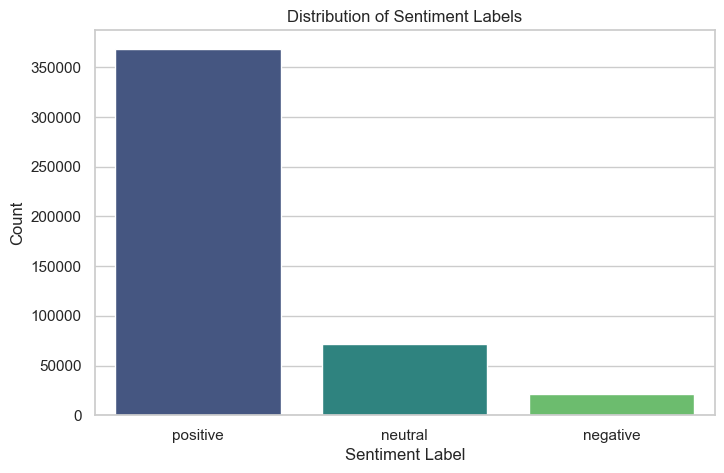

In [42]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")


# Visualization 1: Distribution of Sentiment Labels
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_label', data=data, palette='viridis')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()


In [44]:
# Define a function to get top Course based on sentiment
def get_top_products_by_sentiment(data, sentiment, top_n=5):
    filtered_data = data[data['sentiment_label'] == sentiment]
    product_counts = filtered_data.groupby('course_id').size().reset_index(name='Count')
    top_products = product_counts.sort_values(by='Count', ascending=False).head(top_n)
    return top_products

# Get top 5 Courses for each sentiment category
top_positive = get_top_products_by_sentiment(data, 'positive')
top_negative = get_top_products_by_sentiment(data, 'negative')
top_neutral = get_top_products_by_sentiment(data, 'neutral')

C:\Users\sbedo\AppData\Local\Temp\ipykernel_16276\2285511745.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='course_id', data=top_positive, palette='Greens')


Text(0, 0.5, 'Product ID')

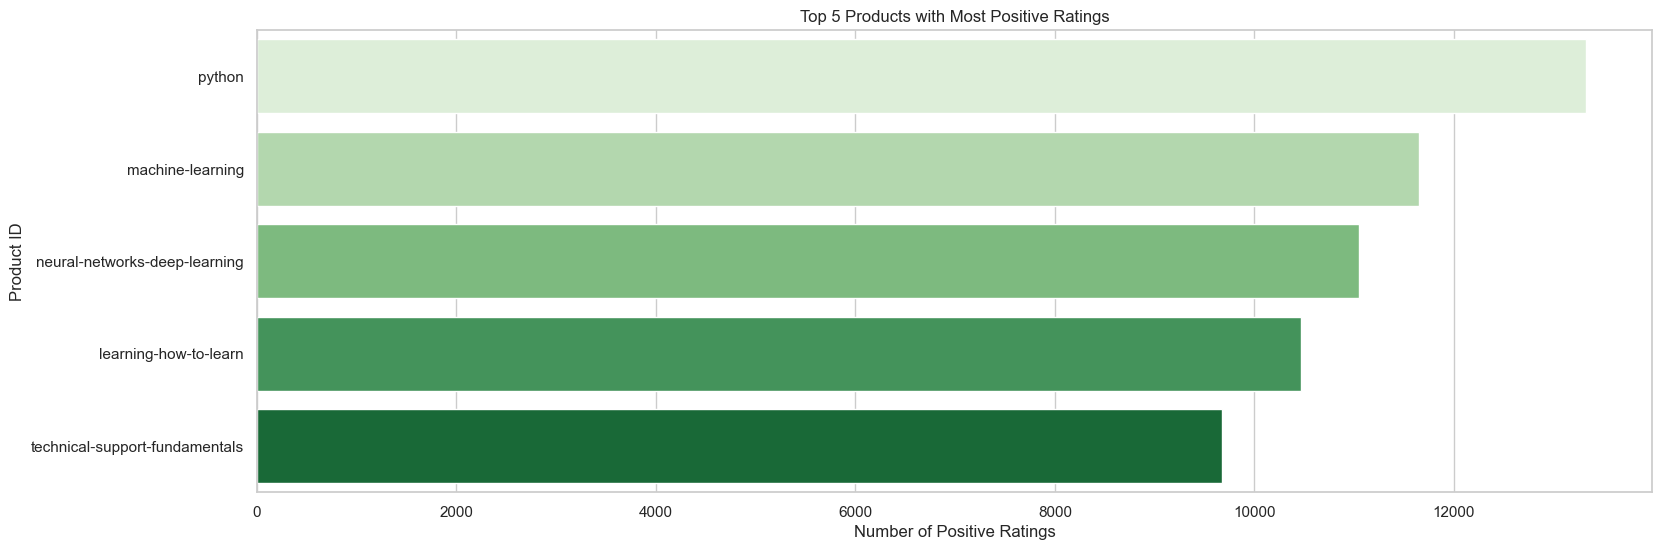

In [46]:
plt.figure(figsize=(18, 6))
sns.barplot(x='Count', y='course_id', data=top_positive, palette='Greens')
plt.title('Top 5 Products with Most Positive Ratings')
plt.xlabel('Number of Positive Ratings')
plt.ylabel('Product ID')

C:\Users\sbedo\AppData\Local\Temp\ipykernel_16276\1729557698.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='course_id', data=top_negative, palette='Reds')


Text(0, 0.5, '')

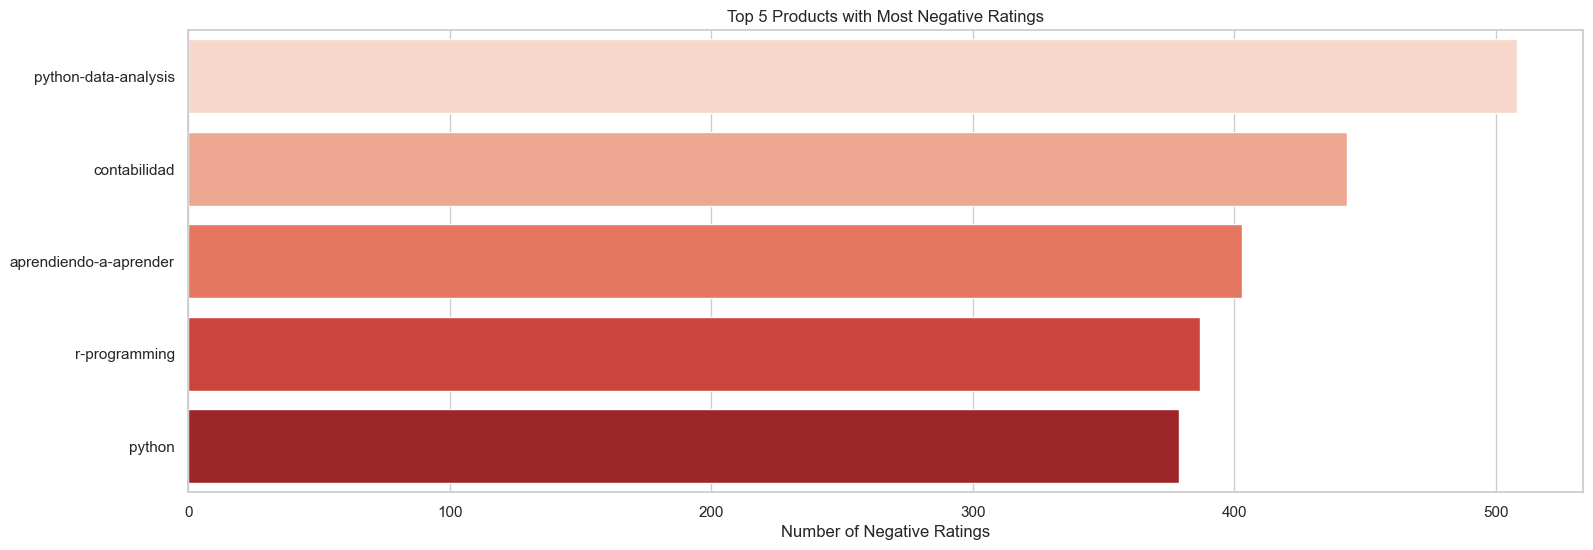

In [47]:
plt.figure(figsize=(18, 6))

# Negative ratings
sns.barplot(x='Count', y='course_id', data=top_negative, palette='Reds')
plt.title('Top 5 Products with Most Negative Ratings')
plt.xlabel('Number of Negative Ratings')
plt.ylabel('')

C:\Users\sbedo\AppData\Local\Temp\ipykernel_16276\2540817543.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='course_id', data=top_neutral, palette='Blues')


Text(0, 0.5, '')

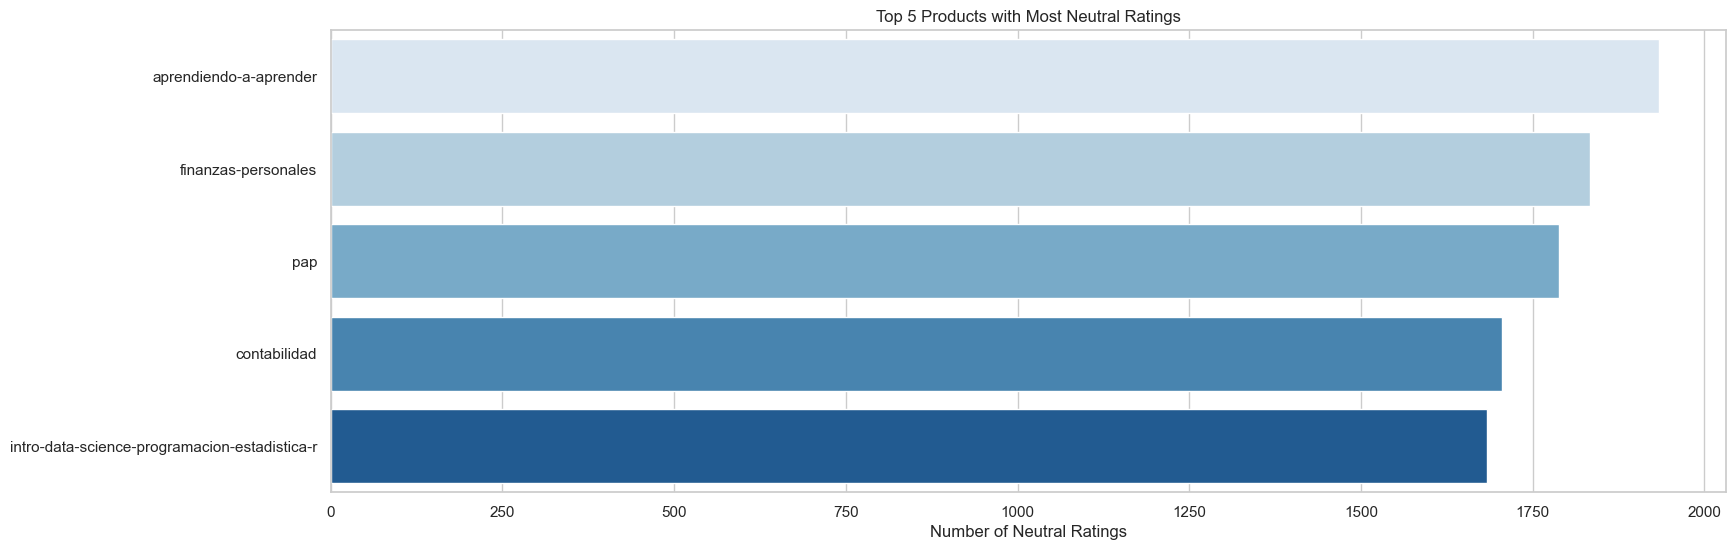

In [48]:
# Neutral ratings
plt.figure(figsize=(18, 6))

sns.barplot(x='Count', y='course_id', data=top_neutral, palette='Blues')
plt.title('Top 5 Products with Most Neutral Ratings')
plt.xlabel('Number of Neutral Ratings')
plt.ylabel('')

## <h2 style = "color:red;">Predictive Model</h2>


In [51]:
# with calculated measures

# Vectorizing the text data
tfidf = TfidfVectorizer(stop_words='english')
text_features = tfidf.fit_transform(data['reviews'])

# Creating a feature matrix by combining text features with sentiment scores
additional_features = data[['pos_score', 'neu_score', 'neg_score', 'compound_score']]
X = hstack([text_features, additional_features])

# Extract the 'Rating' column as the target variable
y = data['rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train, y_train)

# Predict on the test set
y_pred = model1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.798618640759856
Confusion Matrix:
 [[  457    93   158   208   399]
 [  155    97   228   335   444]
 [  137    74   475  1233  1541]
 [   78    19   385  3285 11325]
 [   49     8    86  1618 69341]]
Classification Report:
               precision    recall  f1-score   support

           1       0.52      0.35      0.42      1315
           2       0.33      0.08      0.13      1259
           3       0.36      0.14      0.20      3460
           4       0.49      0.22      0.30     15092
           5       0.83      0.98      0.90     71102

    accuracy                           0.80     92228
   macro avg       0.51      0.35      0.39     92228
weighted avg       0.75      0.80      0.76     92228



In [52]:
# Create a DataFrame from the test set and predictions
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Add the index from y_test to the DataFrame to track original rows
results_df['Index'] = y_test.index

# Find rows where the model's predictions were incorrect
incorrect_predictions = results_df[results_df['Actual'] != results_df['Predicted']]

# Display the indices of incorrect predictions and some additional data if needed
print("Indices of incorrect predictions:", incorrect_predictions['Index'].tolist())
print(incorrect_predictions)  # This will show the actual and predicted values alongside the indices

Indices of incorrect predictions: [773789, 1392991, 237587, 406813, 481870, 517758, 1172126, 24838, 982299, 481152, 241, 385388, 30179, 8360, 1185609, 1283446, 925084, 362876, 237261, 879727, 338518, 290089, 96319, 842206, 791488, 8925, 1418126, 1152747, 1182973, 966168, 361942, 854152, 1357110, 1016265, 854127, 1301916, 605944, 513751, 868184, 1014407, 518224, 517517, 447989, 1174085, 1106508, 1012388, 512376, 457839, 561072, 1029694, 238714, 1339196, 209883, 422248, 1382924, 762804, 1303061, 521629, 1110090, 603785, 238884, 476257, 533518, 1392578, 962566, 140377, 481484, 149193, 941726, 1210955, 1217632, 290928, 1044445, 287194, 912316, 1421199, 267001, 76000, 164143, 250935, 430078, 715161, 1233621, 1110682, 237963, 117714, 541788, 353072, 522179, 1336000, 1221388, 25205, 938819, 1174, 396035, 722065, 113952, 1314966, 200285, 1241532, 491800, 237572, 75413, 684733, 542122, 443953, 362785, 61994, 74864, 830490, 668817, 290690, 1091541, 189072, 1205018, 20246, 976322, 20236, 1253597,